In [83]:
import os
import gzip
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

from collections import defaultdict

# Computing all-all pairwise SW distances over teh K562 dataset

Pulled from /home/brett/work/OrthogonalTrainValSplits/hashClust/scripts/hashFrag_tutorial_previous.ipynb

In [4]:
%%bash

PAIRED_FASTAS_PATH=$HOME/work/OrthogonalTrainValSplits/data/K562_clean/K562_clean_filepaths.txt
OUT_DIR=$HOME/work/OrthogonalTrainValSplits/distances/K562_clean.smith_waterman.1121

N_PARTITIONS=$( cat $PAIRED_FASTAS_PATH | wc -l )
echo $N_PARTITIONS

qsub -t 1:${N_PARTITIONS} pairwise_comparisons_batch.sh $PAIRED_FASTAS_PATH $OUT_DIR # Note: configured to Altair Grid Engine (AGE/SGE) job scheduler!

276
requested Hard Resources
  memory (s_vmem): 4G = A task requires 4GB of memory per slot.
  slots (def_slot): 16 = A task requires 1600% of CPU.
  total memory: 64G = A task requires 64GB of memory.
  Resource list: arm
array job tasks
  SGE_TASK_FIRST: 1
  SGE_TASK_LAST: 276
  SGE_TASK_STEPSIZE: 1
Your job-array 117099925.1-276:1 ("bkSW_BATCH") has been submitted


# Identifying homologous groups

In [5]:
%%bash

WORK_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work
LABEL=hashFrag
BLASTN_PATH=$WORK_DIR/K562_clean.blastn.out
PROCESSED_BLASTN_PATH=$WORK_DIR/K562_clean.blastn.processed.tsv

hashFrag process_blast_results_module \
--blastn-path $BLASTN_PATH \
--processed-blastn-path $PROCESSED_BLASTN_PATH

2025-10-05 07:44:02 - numexpr.utils - INFO - Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2025-10-05 07:44:02 - numexpr.utils - INFO - Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-10-05 07:44:02 - numexpr.utils - INFO - NumExpr defaulting to 16 threads.
2025-10-05 07:44:17 - process_blast_results_module - INFO - Calling module...
2025-10-05 07:46:48 - process_blast_results_module - INFO - Processed BLASTn results written to: /home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/K562_clean.blastn.processed.tsv
2025-10-05 07:46:48 - process_blast_results_module - INFO - Module execution completed.



In [6]:
%%bash

WORK_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work
INPUT_PATH=$WORK_DIR/K562_clean.blastn.processed.tsv
hashFrag filter_candidates_module -i $INPUT_PATH -t 60 -o $WORK_DIR

2025-10-05 07:48:07 - numexpr.utils - INFO - Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2025-10-05 07:48:07 - numexpr.utils - INFO - Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-10-05 07:48:07 - numexpr.utils - INFO - NumExpr defaulting to 16 threads.
2025-10-05 07:48:07 - filter_candidates_module - INFO - Calling module...
2025-10-05 07:49:41 - filter_candidates_module - INFO - Filtered results written to: /home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/hashFrag.similar_pairs.tsv
2025-10-05 07:49:41 - filter_candidates_module - INFO - Module execution completed.



In [10]:
%%bash

WORK_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work
INPUT_PATH=$WORK_DIR/K562_clean.blastn.processed.tsv
OUTPUT_PATH=$WORK_DIR/K562_clean.homologous_groups.csv
hashFrag identify_homologous_groups_module -i $INPUT_PATH -t 60 -o $OUTPUT_PATH

2025-10-05 08:01:30 - numexpr.utils - INFO - Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2025-10-05 08:01:30 - numexpr.utils - INFO - Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-10-05 08:01:30 - numexpr.utils - INFO - NumExpr defaulting to 16 threads.
2025-10-05 08:01:33 - identify_homologous_groups_module - INFO - Calling module...
2025-10-05 08:08:02 - identify_homologous_groups_module - INFO - 95266 distinct groups.
2025-10-05 08:08:02 - identify_homologous_groups_module - INFO - Homologous groups written to: /home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/K562_clean.homologous_groups.csv
2025-10-05 08:08:02 - identify_homologous_groups_module - INFO - Module execution completed.



In [11]:
%%bash

WORK_DIR=/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work
HOMOLOGY_PATH=$WORK_DIR/K562_clean.homologous_groups.csv
OUT_DIR=$WORK_DIR
hashFrag create_orthogonal_folds_module -i $HOMOLOGY_PATH -f 10 -o $OUT_DIR

2025-10-05 08:09:29 - create_orthogonal_folds_module - INFO - Calling module...
2025-10-05 08:09:29 - create_orthogonal_folds_module - INFO - Creating 10 orthogonal folds...
2025-10-05 08:09:29 - create_orthogonal_folds_module - INFO - Orthogonal folds written to /home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/hashFrag.10_orthogonal_folds.tsv
2025-10-05 08:09:29 - create_orthogonal_folds_module - INFO - Module execution completed.



# Validating orthogonal fold creation

In [13]:
folds_path = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work/hashFrag.10_orthogonal_folds.tsv"

In [15]:
folds_df = pd.read_csv(folds_path,sep="\t")
display(folds_df.head())
print(folds_df.shape)

,id,fold
0,HBE1_616,0
1,peak79226_Reversed,0
2,peak48901,0
3,peak44111,0
4,peak82994_Reversed,0


(226253, 2)


In [45]:
K562_clean_idset = set(folds_df["id"])
len(K562_clean_idset)

226253

In [17]:
np.unique(folds_df["fold"],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([23454, 22534, 22534, 22533, 22533, 22533, 22533, 22533, 22533,
        22533]))

In [22]:
ids = set(folds_df["id"])

In [31]:
both_orientations_set = set()
for seq_id in tqdm(ids):
    if seq_id.endswith("_Reversed"):
        complementary_seq_id = seq_id.replace("_Reversed","")
    else:
        complementary_seq_id = seq_id+"_Reversed"
    if complementary_seq_id in ids:
        both_orientations_set.add(seq_id)
        both_orientations_set.add(complementary_seq_id)
print(len(both_orientations_set))

100%|██████████████████████████████████████████████████████████████████| 226253/226253 [00:00<00:00, 1282255.02it/s]

223052


In [32]:
for fold,subset_df in folds_df.groupby("fold"):
    fold_set = set(subset_df["id"])
    for seq_id in fold_set:
        if seq_id in both_orientations_set:
            if seq_id.endswith("_Reversed"):
                complementary_seq_id = seq_id.replace("_Reversed","")
            else:
                complementary_seq_id = seq_id+"_Reversed"
            assert complementary_seq_id in fold_set

# Making chromosomal splits

In [36]:
chrom_path = "/home/brett/work/OrthogonalTrainValSplits/data/K562_clean/id_chrom.csv"
chrom_df = pd.read_csv(chrom_path)
display(chrom_df.head())
print(chrom_df.shape)

,id,chrom
0,peak10,chr1
1,peak10_Reversed,chr1
2,peak1000,chr1
3,peak1000_Reversed,chr1
4,peak10000,chr1


(225948, 2)


In [37]:
chrom_dict = {}
for idx,row in chrom_df.iterrows():
    if row["id"] in ids:
        chrom_dict[row["id"]] = row["chrom"]
print(len(chrom_dict))

225948


In [102]:
chrom_dict = defaultdict(list)
for idx,row in chrom_df.iterrows():
    if row["id"] in ids:
        chrom_dict[row["chrom"]].append(row["id"])


In [103]:
for chrom,group in chrom_dict.items():
    print(chrom,len(group))

chr1 22437
chr10 9139
chr11 18186
chr12 9676
chr13 3424
chr14 5236
chr15 6341
chr16 10807
chr17 9216
chr18 3434
chr19 8132
chr2 19207
chr20 9442
chr21 2705
chr22 4291
chr3 11973
chr4 8567
chr5 9143
chr6 13505
chr7 11189
chr8 12513
chr9 7587
chrX 9749
chrY 49


In [41]:
ids = set(chrom_df["id"])
both_orientations_set = set()
for seq_id in tqdm(ids):
    if seq_id.endswith("_Reversed"):
        complementary_seq_id = seq_id.replace("_Reversed","")
    else:
        complementary_seq_id = seq_id+"_Reversed"
    if complementary_seq_id in ids:
        both_orientations_set.add(seq_id)
        both_orientations_set.add(complementary_seq_id)
print(len(both_orientations_set))

100%|██████████████████████████████████████████████████████████████████| 225948/225948 [00:00<00:00, 1330480.49it/s]

222996


In [94]:
n_folds = 10
cutoff = chrom_df.shape[0] // n_folds
cutoff

22594

In [105]:
folds_count = np.zeros(n_folds)
chroms,counts = np.unique(chrom_df["chrom"],return_counts=True)

chrom_counts_dict = {}
for chrom,count in zip(chroms,counts):
    chrom_counts_dict[chrom] = count

folds = [[] for _ in range(n_folds)]
fold_totals = np.zeros(n_folds, dtype=int)

for chrom in chroms:
    idx = np.argmin(fold_totals)
    folds[idx].append(chrom)
    fold_totals[idx] += chrom_counts_dict[chrom]

folds_dict = {
    "id":[],
    "fold":[],
    "chrom":[]
}
for f,fold in enumerate(folds):
    for chrom in fold:
        for seq_id in chrom_dict[chrom]:
            folds_dict["id"].append(seq_id)
            folds_dict["fold"].append(f)
            folds_dict["chrom"].append(chrom)

chrom_folds_df = pd.DataFrame(folds_dict)
print(chrom_folds_df["fold"].nunique())
display(chrom_folds_df.head())
print(chrom_folds_df.shape)

out_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work"
outpath = os.path.join(out_dir,f"control.10_chromosomal_folds.tsv.gz")
chrom_folds_df.to_csv(outpath,compression="gzip",sep="\t",index=False)

10


,id,fold,chrom
0,peak10,0,chr1
1,peak10_Reversed,0,chr1
2,peak1000,0,chr1
3,peak1000_Reversed,0,chr1
4,peak10000,0,chr1


(225948, 3)


# Computing min cross-fold distances

In [65]:
input_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/blast/K562_clean.complete.wordsize_7.work"
chrom_folds_path = os.path.join(input_dir,"control.10_chromosomal_folds.tsv.gz")
hashfrag_folds_path = os.path.join(input_dir,"hashFrag.10_orthogonal_folds.tsv.gz")

distances_dir = "/home/brett/work/OrthogonalTrainValSplits/distances/K562_clean.smith_waterman.1121"

In [106]:
chrom_folds_df = pd.read_csv(chrom_folds_path,sep="\t")
hashfrag_folds_df = pd.read_csv(hashfrag_folds_path,sep="\t")

display(chrom_folds_df.head())
print(chrom_folds_df.shape)

display(hashfrag_folds_df.head())
print(hashfrag_folds_df.shape)

,id,fold,chrom
0,peak10,0,chr1
1,peak10_Reversed,0,chr1
2,peak1000,0,chr1
3,peak1000_Reversed,0,chr1
4,peak10000,0,chr1


(225948, 3)


,id,fold
0,HBE1_616,0
1,peak79226_Reversed,0
2,peak48901,0
3,peak44111,0
4,peak82994_Reversed,0


(226253, 2)


In [107]:
chrom_folds_dict = defaultdict(set)
for fold,subset_df in chrom_folds_df.groupby("fold"):
    chrom_folds_dict[fold] = set(subset_df["id"])

hashfrag_folds_dict = defaultdict(set)
for fold,subset_df in hashfrag_folds_df.groupby("fold"):
    hashfrag_folds_dict[fold] = set(subset_df["id"])


In [108]:
chrom_fold_map = {}
for seq_id,fold in zip(chrom_folds_df["id"],chrom_folds_df["fold"]):
    chrom_fold_map[seq_id] = fold

hashfrag_fold_map = {}
for seq_id,fold in zip(hashfrag_folds_df["id"],hashfrag_folds_df["fold"]):
    hashfrag_fold_map[seq_id] = fold

In [109]:
n_chrom_folds = len(chrom_folds_dict)
n_hashfrag_folds = len(hashfrag_folds_dict)
chrom_arr = np.zeros(shape=(n_chrom_folds,n_chrom_folds))
hashfrag_arr = np.zeros(shape=(n_hashfrag_folds,n_hashfrag_folds))
pattern = os.path.join(distances_dir,"*.txt.gz")
for distances_path in glob(pattern):
    print(os.path.basename(distances_path))
    with gzip.open(distances_path,"rt") as handle:
        handle.readline()
        for line in tqdm(handle):
            id_i,id_j,d = line.strip().split(",")
            d = float(d)
            try:
                i = chrom_fold_map[id_i]
                j = chrom_fold_map[id_j]
                chrom_arr[i,j] = max(chrom_arr[i,j],d)
                chrom_arr[j,i] = max(chrom_arr[j,i] ,d)
            except:
                pass
            
            try:
                i = hashfrag_fold_map[id_i]
                j = hashfrag_fold_map[id_j]
                hashfrag_arr[i,j] = max(hashfrag_arr[i,j],d)
                hashfrag_arr[j,i] = max(hashfrag_arr[j,i],d)
            except:
                pass
    break

K562_clean.part_003.part_022.txt.gz.pairwise_comparisons.batch.txt.gz


100000000it [05:02, 330434.67it/s]


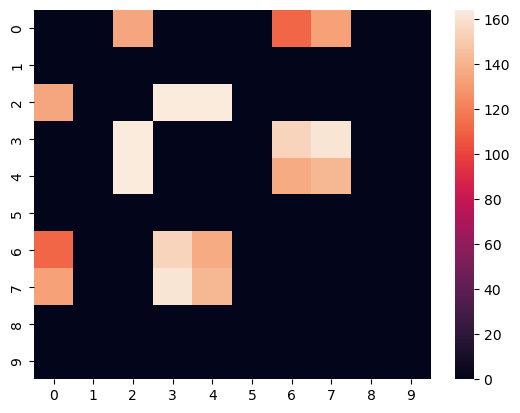

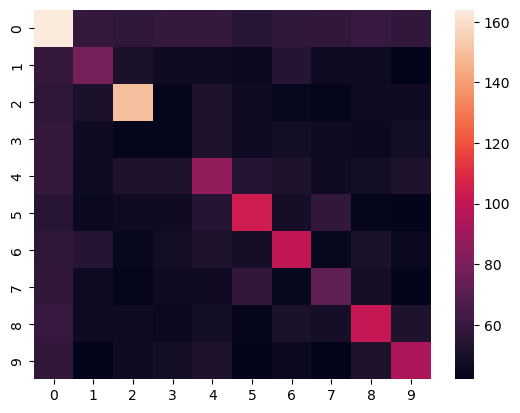

In [110]:
sns.heatmap(chrom_arr)
plt.show()
sns.heatmap(hashfrag_arr)
plt.show()

# Aggregating full results

In [111]:
analysis_dir = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/cross_fold_max_sw_analysis"

In [116]:
pattern = os.path.join(analysis_dir,"*.chromosomal.max_sw_score.csv.gz")
pathlist = glob(pattern)
arrs = [pd.read_csv(path,index_col=0).to_numpy() for path in pathlist]
arr = np.max(np.stack(arrs,axis=0),axis=0)
arr

array([[200., 186., 190., 184., 189., 181., 188., 182., 188., 187.],
       [186., 200., 184., 188., 188., 181., 186., 186., 187., 185.],
       [190., 184., 200., 181., 185., 185., 188., 191., 192., 192.],
       [184., 188., 181., 200., 187., 185., 179., 184., 189., 183.],
       [189., 188., 185., 187., 200., 184., 191., 185., 188., 185.],
       [181., 181., 185., 185., 184., 200., 181., 183., 186., 180.],
       [188., 186., 188., 179., 191., 181., 200., 190., 192., 189.],
       [182., 186., 191., 184., 185., 183., 190., 200., 190., 182.],
       [188., 187., 192., 189., 188., 186., 192., 190., 200., 188.],
       [187., 185., 192., 183., 185., 180., 189., 182., 188., 200.]])

In [119]:
max_chrom_df = pd.DataFrame(arr)
max_chrom_df

,0,1,2,3,4,5,6,7,8,9
0,200.0,186.0,190.0,184.0,189.0,181.0,188.0,182.0,188.0,187.0
1,186.0,200.0,184.0,188.0,188.0,181.0,186.0,186.0,187.0,185.0
2,190.0,184.0,200.0,181.0,185.0,185.0,188.0,191.0,192.0,192.0
3,184.0,188.0,181.0,200.0,187.0,185.0,179.0,184.0,189.0,183.0
4,189.0,188.0,185.0,187.0,200.0,184.0,191.0,185.0,188.0,185.0
5,181.0,181.0,185.0,185.0,184.0,200.0,181.0,183.0,186.0,180.0
6,188.0,186.0,188.0,179.0,191.0,181.0,200.0,190.0,192.0,189.0
7,182.0,186.0,191.0,184.0,185.0,183.0,190.0,200.0,190.0,182.0
8,188.0,187.0,192.0,189.0,188.0,186.0,192.0,190.0,200.0,188.0
9,187.0,185.0,192.0,183.0,185.0,180.0,189.0,182.0,188.0,200.0


In [120]:
pattern = os.path.join(analysis_dir,"*.hashFrag.max_sw_score.csv.gz")
pathlist = glob(pattern)
arrs = [pd.read_csv(path,index_col=0).to_numpy() for path in pathlist]
arr = np.max(np.stack(arrs,axis=0),axis=0)
arr

array([[200.,  63.,  65.,  62.,  64.,  64.,  62.,  68.,  64.,  62.],
       [ 63., 200.,  61.,  63.,  63.,  61.,  61.,  62.,  62.,  64.],
       [ 65.,  61., 200.,  62.,  61.,  61.,  61.,  62.,  62.,  62.],
       [ 62.,  63.,  62., 200.,  62.,  61.,  63.,  61.,  63.,  61.],
       [ 64.,  63.,  61.,  62., 200.,  62.,  62.,  63.,  64.,  61.],
       [ 64.,  61.,  61.,  61.,  62., 200.,  60.,  63.,  63.,  60.],
       [ 62.,  61.,  61.,  63.,  62.,  60., 200.,  64.,  64.,  62.],
       [ 68.,  62.,  62.,  61.,  63.,  63.,  64., 200.,  62.,  61.],
       [ 64.,  62.,  62.,  63.,  64.,  63.,  64.,  62., 200.,  70.],
       [ 62.,  64.,  62.,  61.,  61.,  60.,  62.,  61.,  70., 200.]])

In [121]:
max_hashFrag_df = pd.DataFrame(arr)
max_hashFrag_df

,0,1,2,3,4,5,6,7,8,9
0,200.0,63.0,65.0,62.0,64.0,64.0,62.0,68.0,64.0,62.0
1,63.0,200.0,61.0,63.0,63.0,61.0,61.0,62.0,62.0,64.0
2,65.0,61.0,200.0,62.0,61.0,61.0,61.0,62.0,62.0,62.0
3,62.0,63.0,62.0,200.0,62.0,61.0,63.0,61.0,63.0,61.0
4,64.0,63.0,61.0,62.0,200.0,62.0,62.0,63.0,64.0,61.0
5,64.0,61.0,61.0,61.0,62.0,200.0,60.0,63.0,63.0,60.0
6,62.0,61.0,61.0,63.0,62.0,60.0,200.0,64.0,64.0,62.0
7,68.0,62.0,62.0,61.0,63.0,63.0,64.0,200.0,62.0,61.0
8,64.0,62.0,62.0,63.0,64.0,63.0,64.0,62.0,200.0,70.0
9,62.0,64.0,62.0,61.0,61.0,60.0,62.0,61.0,70.0,200.0


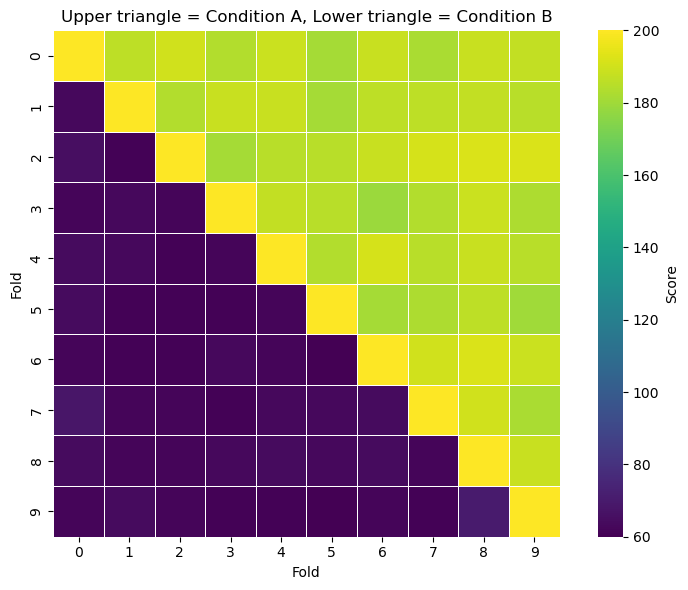

In [126]:
mask_upper = np.triu(np.ones(max_chrom_df.shape, dtype=bool))  # includes diagonal
mask_lower = np.tril(np.ones(max_chrom_df.shape, dtype=bool))  # includes diagonal
combined_df = max_chrom_df.where(mask_upper, max_hashFrag_df)
combined_df = combined_df.astype(float)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    combined_df,
    cmap="viridis",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Score"},
)

plt.title("Upper triangle = Condition A, Lower triangle = Condition B")
plt.xlabel("Fold")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

In [127]:
max_hashFrag_df.iloc[0,1]

63.0

In [128]:
results_dict = {
    "fold_i":[],
    "fold_j":[],
    "max_sw_score":[],
    "condition":[]
}
for i in range(n_folds):
    for j in range(n_folds):
        if i < j:
            results_dict["fold_i"].append(i)
            results_dict["fold_j"].append(j)
            results_dict["max_sw_score"].append(max_chrom_df.iloc[i,j])
            results_dict["condition"].append("Chromosomal folds")
        else:
            results_dict["fold_i"].append(i)
            results_dict["fold_j"].append(j)
            results_dict["max_sw_score"].append(max_hashFrag_df.iloc[i,j])
            results_dict["condition"].append("hashFrag folds")
        # value = some_matrix[i, j]
        # condition = "A" if i < j else "B"
        # rows.append((i, j, value, condition))

results_df = pd.DataFrame(results_dict)
display(results_df.head())
print(results_df.shape)

,fold_i,fold_j,max_sw_score,condition
0,0,0,200.0,hashFrag folds
1,0,1,186.0,Chromosomal folds
2,0,2,190.0,Chromosomal folds
3,0,3,184.0,Chromosomal folds
4,0,4,189.0,Chromosomal folds


(100, 4)


In [129]:
outpath = "/home/brett/work/OrthogonalTrainValSplits/K562_orthoSplit/analysis/cross_fold_max_sw_analysis/aggregated.split.cross_fold_analysis.csv.gz"
results_df.to_csv(outpath,index=False,compression="gzip")